<a href="https://colab.research.google.com/github/KwanHoo/coding-playground/blob/main/ML_01_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 자동차 연비 예측하기: 회귀

Note: 이 실습은 tensorflow에 있는 자료를 바탕으로 좀더 간단하게 변형하여 ML 기초학습을 할 수 있게 오픈 소스 개발자 대회에서 제공하는 온라인 강의를 수강하면서, 구글 코랩을 이용하여 실습 수업을 진행하면서 정리하고 메모한 자료입니다.

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와는 달리 *분류*(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것).

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

이 예제는 `tf.keras` API를 사용합니다. 자세한 내용은 [케라스 가이드](https://www.tensorflow.org/guide/keras)를 참고하세요.

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


## Auto MPG 데이터셋

이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.

### 데이터 구하기
먼저 데이터셋을 다운로드합니다.  
csv 파일의 데이터 셋을 다운받음  
파이썬에서는 데이터셋을 판다스로 읽어야함

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

40960/30286 [========================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

판다스를 사용하여 데이터를 읽습니다.

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.head() # origin은 나라를 숫자로 표현

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
len(dataset) # 398개의 데이터

398

### 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [8]:
dataset = dataset.dropna()

In [9]:
len(dataset) # 누락된 6개가 제거가 됨

392

`"Origin"` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:

In [10]:
origin = dataset.pop('Origin')

In [11]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [12]:
train_dataset = dataset.sample(frac=0.8,random_state=0)  # 80%는 트레이닝에 쓰겠다
test_dataset = dataset.drop(train_dataset.index)

In [13]:
len(train_dataset), len(test_dataset)

(314, 78)

### 데이터 조사하기 (정규화 화기전 작업)

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

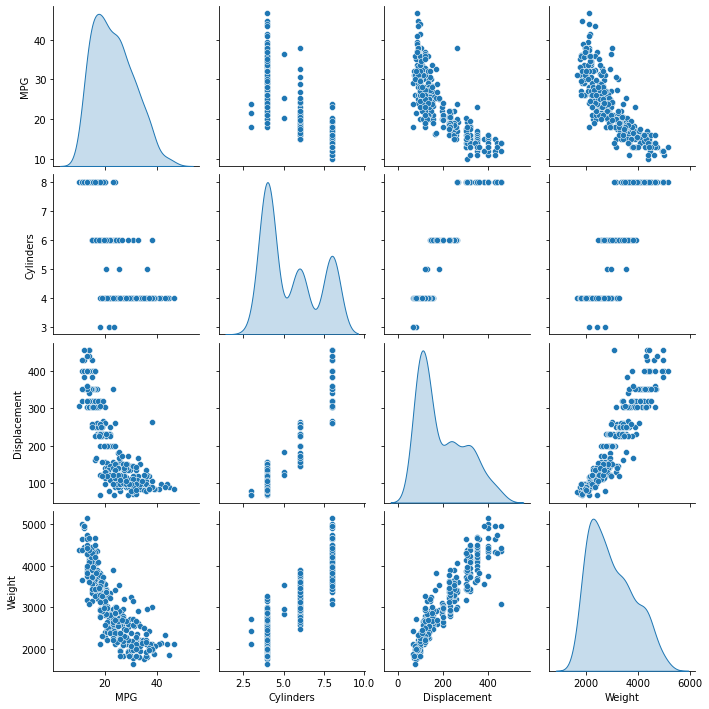

In [14]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계도 확인해 보죠:

In [15]:
train_stats = train_dataset.describe()  # describe()함수를 통해서 평균값과 표준편차를 확인할 수 있음
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [16]:
train_labels = train_dataset.pop('MPG') # mpg는 맞추어야 하는 값이므로 정규화를 하지 않음(빼줌) 
test_labels = test_dataset.pop('MPG') # y값 으로 저장해줌

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.

In [17]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']   # 평균값을 뺀것을 표준편차로 나눔(정규화)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


In [19]:
normed_train_data.shape

(314, 9)

정규화된 데이터를 사용하여 모델을 훈련합니다.

주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

## 모델

### 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 `Sequential` 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다. 나중에 두 번째 모델을 만들기 쉽도록 `build_model` 함수로 모델 구성 단계를 감싸겠습니다.

In [21]:
# 행렬 정의 부분
inputs = keras.Input(shape=(normed_train_data.shape[1],))
h = layers.Dense(64)(inputs)  # 6짜리 피쳐가 들어가고 나는 64짜리로 만듬 (숫자는 암꺼나 해도됨)
h = layers.Activation('relu')(h)  # 활성함수 추가!!!
h = layers.Dense(32, activation='relu')(h) # 활성함수 추가!!

outputs = layers.Dense(1)(h)  # output y를 1로

In [22]:
model = keras.Model(inputs=inputs, outputs=outputs)


# 선형 회귀 : y = x * w + b
y값을 오차를 줄여나가면서 학습  
모델의 예측값과 실제 y값의 차이를 점점 줄여나가는 머신러닝의 원리  
차이를 어떻게 정의할 것인가를 케라스에게 얘기해줘야함  
여기서는 mean squared error를 사용했음  
optimizer는 기본적으로 rmsprop이나 adam을 주로 사용함

In [23]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001))

### 모델 확인

`.summary` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [24]:
model.summary()  # 시각화 API , input과 중간(히든레이어), 마지막 아웃풋 레이어를 확인할 수 있음

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


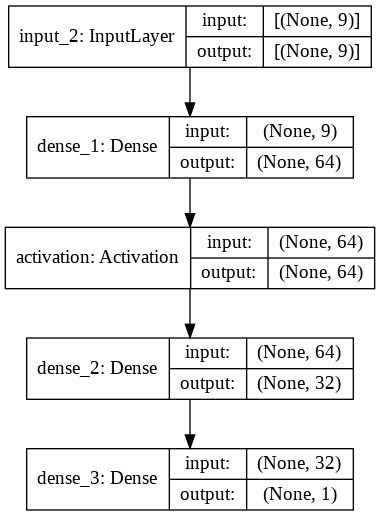

In [25]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True) # 위보다 layer를 좀더 시각화해서 표현

모델을 한번 실행해 보죠. 훈련 세트에서 `5` 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출해 보겠습니다.

In [26]:
normed_train_data[:5].shape

(5, 9)

In [27]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)  # 학습이 전혀안된 모델이지만,학습전에 모델이 작동하는지 predict을 해봄
example_result

array([[-0.30246523],
       [-0.28543147],
       [ 0.4183871 ],
       [-0.3365946 ],
       [-0.02821867]], dtype=float32)

제대로 작동하는 것 같네요.

### 모델 훈련

이 모델을 100번의 에포크(epoch) 동안 훈련합니다. 훈련 정확도와 검증 정확도는 `history` 객체에 기록됩니다.

In [28]:
# # 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
# class PrintDot(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs):
#     if epoch % 100 == 0: print('')
#     print('.', end='')

# training / validation / test
# validation은 학습에 사용되지 않은 데이터이고
# 오버피팅인지 판단하게됨

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2) # 생략 verbose=0, callbacks=[PrintDot()]

# 트레이닝 로스랑, 벨리데이션 로스 둘다 줄어들고 있음

Epoch 1/100
8/8 [==============================] - 1s 33ms/step - loss: 574.3360 - val_loss: 574.2134
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 534.7842 - val_loss: 536.5117
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 500.6136 - val_loss: 499.5923
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 465.8963 - val_loss: 460.5657
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 428.8709 - val_loss: 419.2842
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 388.8841 - val_loss: 373.8403
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 345.4460 - val_loss: 325.2705
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 300.8736 - val_loss: 278.6223
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 256.7433 - val_loss: 231.2205
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 213.0469 - val_los

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해 보죠.

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,6.329306,8.116203,95
96,6.380760,7.987390,96
97,6.408329,7.983532,97
98,6.338707,8.235367,98
99,6.486071,7.955573,99


이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. `model.fit` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 에포크마다 훈련 상태를 점검하기 위해 *EarlyStopping 콜백(callback)*을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

이 콜백에 대해 더 자세한 내용은 [여기](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping)를 참고하세요.

In [30]:
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
# 얼리스타핑 -> 수동으로 찾는게 아니라 자동으로 트레이닝 멈추는 부분을 찾음
# patience= 10의 의미 :  validation 로스가 10번이상 줄어들지 않으면 epoch을 그만할래 라는 의미
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, callbacks=[early_stop])

Epoch 1/100
8/8 [==============================] - 0s 13ms/step - loss: 6.3763 - val_loss: 7.8852
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 6.1933 - val_loss: 8.1766
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 6.2661 - val_loss: 7.7824
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 6.2987 - val_loss: 7.7462
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 6.1963 - val_loss: 8.2169
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 6.3618 - val_loss: 7.7414
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 6.3680 - val_loss: 7.7811
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 6.2448 - val_loss: 7.8785
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 6.2524 - val_loss: 7.8740
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 6.2157 - val_loss: 8.0962
Epoch 11/100
8/8 [==========

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

In [31]:
# evalutate 를 사용하여 평가를 함 / loss 차이가 10정도나는 모델이 만들어짐

loss = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(loss))

3/3 - 0s - loss: 5.4529
테스트 세트의 평균 절대 오차:  5.45 MPG


## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

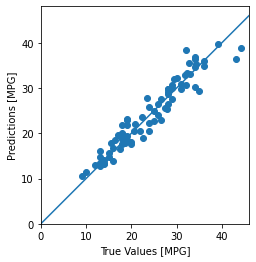

In [32]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


간단한 모델로 구현을 해보았는데, 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴 보죠.

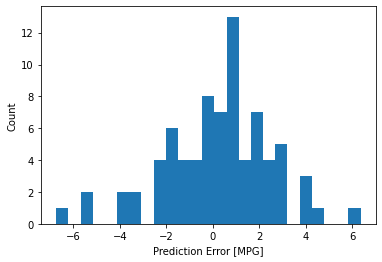

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

## 결론

이 노트북은 non-linear regression 문제를 위한 기법을 소개합니다.

- 이전 선형 회귀에 비해서 성능이 더 좋아졌음
- model에 relu 활성함수를 추가
- loss가 6점대로 줄었음
- 평균 오차도 5.4로 선형보다 줄었음
